# Primena GCN-a nad Cora skupom podataka

Cilj je predvideti vrstu naučnog rada na osnovu citiranih radova\
Skup podataka je dat kao niz čvorova koji predstavljaju atribute radova, dok grana između čvora $i$ i čvora $j$ označava da rad $i$ citira rad $j$ 

## Paketi

In [1]:
%pip install torch_geometric torch


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import pandas as pd
import models
import numpy as np
import random
import helpers

## Ucitavanje podataka

In [3]:
edge_path = './data/cora/cora.cites'
data_path = './data/cora/cora.content'

Učitavamo podatke sa zadate putanje

In [4]:
data = []
edges = []
with open(data_path, 'r') as f:
    data.extend(f.read().splitlines())
with open(edge_path, 'r') as f:
    edges.extend(f.read().splitlines())

## Priprema podataka o čvorovima

Podatke delimo na 3 dela
- Ime tj id čvora
- Feature-e svakog čvora
- Ciljni atribut, tj temu naučnog rada

In [5]:
# Split - 1. element je id cvora, od 2. do zadnjeg su featuri, zadnji je klasa
ids = []
features = []
targets = []

for row in data:
    split_row = row.split('\t')
    ids.append(split_row[0])
    feature_row = list(map(int, split_row[1:-1]))
    features.append(feature_row)
    targets.append(split_row[-1])


Odredimo i preslikavanje, tj kako se kodira svaka tema (koristimo one hot encoding)

In [6]:
def get_onehot(num, max):
    res = np.zeros(max)
    res[num] = 1
    return list(map(int,res))
unique = np.unique(targets)
target_map = {str(x): get_onehot(y, len(unique)) for y,x in enumerate(unique)}

target_map

{'Case_Based': [1, 0, 0, 0, 0, 0, 0],
 'Genetic_Algorithms': [0, 1, 0, 0, 0, 0, 0],
 'Neural_Networks': [0, 0, 1, 0, 0, 0, 0],
 'Probabilistic_Methods': [0, 0, 0, 1, 0, 0, 0],
 'Reinforcement_Learning': [0, 0, 0, 0, 1, 0, 0],
 'Rule_Learning': [0, 0, 0, 0, 0, 1, 0],
 'Theory': [0, 0, 0, 0, 0, 0, 1]}

In [7]:
targets = list(map(lambda x: target_map[x], targets))
targets

[[0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0,

Odredimo jos preslikavanje id-eva na indeks reda čvora u matrici

In [8]:
id_map = {int(x): y for y, x in enumerate(ids)}
id_map

{31336: 0,
 1061127: 1,
 1106406: 2,
 13195: 3,
 37879: 4,
 1126012: 5,
 1107140: 6,
 1102850: 7,
 31349: 8,
 1106418: 9,
 1123188: 10,
 1128990: 11,
 109323: 12,
 217139: 13,
 31353: 14,
 32083: 15,
 1126029: 16,
 1118017: 17,
 49482: 18,
 753265: 19,
 249858: 20,
 1113739: 21,
 48766: 22,
 646195: 23,
 1126050: 24,
 59626: 25,
 340299: 26,
 354004: 27,
 242637: 28,
 1106492: 29,
 74975: 30,
 1152272: 31,
 100701: 32,
 66982: 33,
 13960: 34,
 13966: 35,
 66990: 36,
 182093: 37,
 182094: 38,
 13972: 39,
 13982: 40,
 16819: 41,
 273152: 42,
 237521: 43,
 1153703: 44,
 32872: 45,
 284025: 46,
 218666: 47,
 16843: 48,
 1153724: 49,
 1153728: 50,
 158098: 51,
 8699: 52,
 1134865: 53,
 28456: 54,
 248425: 55,
 1112319: 56,
 28471: 57,
 175548: 58,
 696345: 59,
 28485: 60,
 1139195: 61,
 35778: 62,
 28491: 63,
 310530: 64,
 1153784: 65,
 1481: 66,
 1153786: 67,
 13212: 68,
 1111614: 69,
 5055: 70,
 4329: 71,
 330148: 72,
 1105062: 73,
 4330: 74,
 5062: 75,
 4335: 76,
 158812: 77,
 40124: 78,

## Priprema podataka o granama

Obradićemo grane kako bi odredili matricu susedstva

In [9]:
print(f'Imamo {len(features)} cvorova')

Imamo 2708 cvorova


In [10]:
A = np.zeros((len(features),len(features)))
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
for edge in edges:
    start_id, end_id = list(map(int, edge.split('\t')))
    start_index = id_map[start_id]
    end_index = id_map[end_id]
    A[start_index,end_index] = 1
    A[end_index,start_index] = 1
A
    

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Opšte karakteristike skupa podataka

In [12]:
print(f'Feature-a po cvoru: {len(features[0])}')
print(f'Broj klasa: {len(unique)}')
print(50*'=')

print(f'Broj cvorova: {len(features)}')
print(f'Broj grana: {len(edges)}')

Feature-a po cvoru: 1433
Broj klasa: 7
Broj cvorova: 2708
Broj grana: 5429


Za trening potrebne su nam 3 matrice
- A - matrica susedstva, velicine 2708x2708
- X - matrica feature-a, velicine 2708x1433
- y - matrica ciljnih onehot labela, velicine 2708x7

In [13]:
X = np.array(features)
y = np.array(targets)

In [14]:
print(A.shape)
print(X.shape)
print(y.shape)

(2708, 2708)
(2708, 1433)
(2708, 7)


## Trening

In [25]:
input_dim = X.shape[1]
output_dim = y.shape[1]

In [16]:
# Random biramo indekse čvorova za koje ćemo vršiti trening, ostali čvorovi služe za testiranje
train_test_ratio = 0.2
test_size = int(len(y) * train_test_ratio)

test_mask = [[1] if x<test_size else [0] for x in range(len(y))]
train_mask = [[1-x[0]] for x in test_mask]

In [17]:
df = pd.DataFrame(X)

In [18]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
count,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,...,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000
mean,0.005908,0.012186,0.025849,0.026588,0.060931,0.002585,0.010709,0.002954,0.011817,0.002216,...,0.040620,0.026219,0.017356,0.042097,0.010340,0.001108,0.012555,0.002216,0.024003,0.004431
std,0.076653,0.109736,0.158715,0.160905,0.239247,0.050786,0.102948,0.054282,0.108081,0.047027,...,0.197446,0.159814,0.130618,0.200849,0.101176,0.033272,0.111366,0.047027,0.153086,0.066433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Epoch 1/300, Total Loss: 1.558548606770897
Epoch 2/300, Total Loss: 1.525882528732672
Epoch 3/300, Total Loss: 1.5015116186305428
Epoch 4/300, Total Loss: 1.4798748493009666
Epoch 5/300, Total Loss: 1.4648177375556168
Epoch 6/300, Total Loss: 1.4501945403581826
Epoch 7/300, Total Loss: 1.4364961438055486
Epoch 8/300, Total Loss: 1.4241145408139506
Epoch 9/300, Total Loss: 1.4151794325738571
Epoch 10/300, Total Loss: 1.3999200704916628
Epoch 11/300, Total Loss: 1.390818804141794
Epoch 12/300, Total Loss: 1.3733438189950855
Epoch 13/300, Total Loss: 1.3638920692783258
Epoch 14/300, Total Loss: 1.34651938790665
Epoch 15/300, Total Loss: 1.3371334909000143
Epoch 16/300, Total Loss: 1.3191762455649485
Epoch 17/300, Total Loss: 1.3052139516244996
Epoch 18/300, Total Loss: 1.2862817751244238
Epoch 19/300, Total Loss: 1.2711511878455808
Epoch 20/300, Total Loss: 1.2500113486315378
Epoch 21/300, Total Loss: 1.2304063639662661
Epoch 22/300, Total Loss: 1.2096626622613833
Epoch 23/300, Total Loss

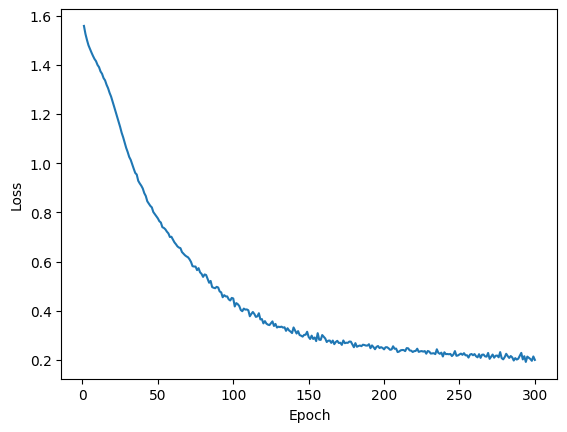

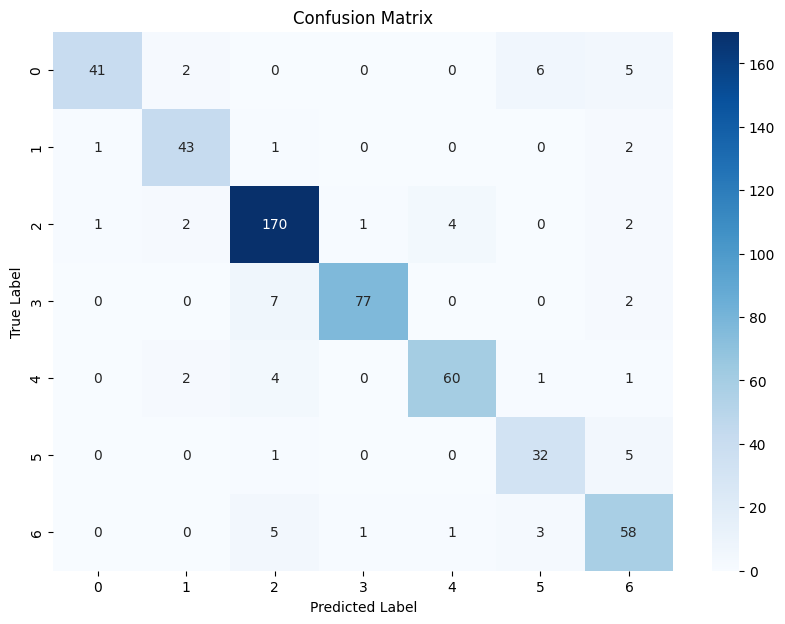

Name:GCN_1433x16x16x7, Accuracy:0.88909426987061


In [ ]:
hidden_dims = [[16, 16]]
epoch_results = []
for hd in hidden_dims:
    gcn = models.GCN(input_dim, hd, output_dim, activation=helpers.ActivationFunctions.swish, dropout_rate=0.2, start_lr=0.5, learning_rate=helpers.LearningRate.static_lr)
    gcn.train(A, X, y, 300, mask = train_mask)
    accuracy = gcn.measure_accuracy(A, X, y, test_mask)
    gcn.confusion_matrix(A, X, y,test_mask)
    print(f'Name:{gcn.get_name()}, Accuracy:{accuracy}')
    print(50*'=')

## Prednost graf konvolucione mreze

In [20]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score

In [21]:
label_encoded_target = np.array([int(np.argmax(x)) for x in y])

In [22]:
train_indices = [i for i,x in enumerate(train_mask) if x == [1]]
test_indices  = [i for i,x in enumerate(test_mask) if x == [1]]

In [23]:
X_train = X[train_indices]
y_train = label_encoded_target[train_indices]

X_test = X[test_indices]
y_test = label_encoded_target[test_indices]

In [24]:
rfc = RFC(n_estimators=300)
rfc.fit(X_train, y_train)
print(f'Random forest, 300 estimators - Accuracy: {accuracy_score(y_test, rfc.predict(X_test))}')

Random forest, 300 estimators - Accuracy: 0.711645101663586
